# CMPS 242 2017 Fall HW3 

# Spam SMS Using Logistic Regression

### *Group: Jiahui Wei(jwei19), Ran Xu(rxu3), Yunzheng Zhang(yzhan300)*

## Homework Objective

Use gradient descent to train a logistic regression model to identify spam SMS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
%matplotlib inline

## TF-IDF

TF-IDF storts for term frequency–inverse document frequency,  is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

Load the data and set ham as 0, spam as 1.

In [2]:
train_data = pd.read_csv("./data/train.csv")
train_data["label_num"] = train_data.label.map({"ham": 0, "spam": 1})

test_data = pd.read_csv('./data/test.csv')
test_data["label_num"] = test_data.label.map({"ham": 0, "spam": 1})

X_train, y_train = train_data["sms"], train_data["label_num"]
y_train = y_train.values.reshape(y_train.shape[0], 1)

X_test, y_test = test_data["sms"], test_data["label_num"]
y_test = y_test.values.reshape(y_test.shape[0], 1)

Use *CounterVectorizer* to tokenize the training data and transform both training data and test data to a feature vector.

In [3]:
count_vec = CountVectorizer(
    decode_error='ignore', stop_words=stopwords.words("english"))
X_train_count = count_vec.fit_transform(X_train)
X_test_count = count_vec.transform(X_test)

Use *TfidfTransformer* to transform the word count feature vector to tf-idf feature vector.

In [4]:
tfidf_trans = TfidfTransformer()
X_train_tfidf = tfidf_trans.fit_transform(X_train_count)
X_test_tfidf = tfidf_trans.transform(X_test_count)

Use *PCA* to reduce the feature dimensions to the same as the sample number

In [5]:
pca = PCA()
X_train_tfidf_rd = pca.fit_transform(X_train_tfidf.toarray())
X_test_tfidf_rd = pca.transform(X_test_tfidf.toarray())

## Logistic Regression

Use $\lambda\sum||\omega||^2$ as the regularizer

Define the sigmoid function.

In [6]:
def sigmoid(Y):
    return 1 / (1 + np.exp(-Y))

Define the Gradient Decent function. Use a while loop to do GD and use the change of loss to determine whether to stop or not. Max number of iterations is set to prevent endless loop when not converged. 

Loss function:

$$E(w)=-\sum_{n=1}^N\{t_n\ln y_n+(1-t_n)\ln(1-y_n)\}+\lambda ||\omega||^2$$

Gradient:

$$\nabla E(w)=\sum^N_{n=1}(y_n-t_n)\phi_n+\lambda \omega$$

**Note**: If *y_predict* is very close to 1, like 0.9999999, the result *1-y_predict* is 0 which will cause nan when calculating $(1-y)*\log(1-y)$. Therefore *n_y_predict* is set to prevent *1-y_predict* to be 0

In [263]:
def gradient_decent(X, y, w, lambda_):
    iternum = 0
    alpha = 0.9
    max_iter = 10000
    ita = 2
    eps = 10**(-3)

    y_predict = sigmoid(np.dot(X, w))
    error = -sum(y * np.log(y_predict) +
                 (1 - y) * np.log(1 - y_predict)) + lambda_ / 2.0 * np.dot(
                     w.transpose(), w)

    while iternum < max_iter:
        iternum = iternum + 1

        delta_w = np.dot(X.transpose(), (y_predict - y)) + w * lambda_
        w = w - (ita * iternum**(-alpha) * delta_w)
        y_predict = sigmoid(np.dot(X, w))
        n_y_predict = 1 - y_predict
        n_y_predict[n_y_predict < 10**(-5)] = 10**(-5)
        new_error = -sum(y * np.log(y_predict) + (1 - y) * np.log(n_y_predict)
                         ) + lambda_ / 2.0 * np.dot(w.transpose(), w)

        if abs(error - new_error) < eps:
            break
        error = new_error


#         if iternum%1000==0:
#             print lambda_,error
    print lambda_,iternum,error
    return w

Define a function to calculate the accuracy when $\omega$ and data is provided

In [8]:
def cal_accuracy(X, w, t):
    y = sigmoid(np.dot(X, w)) >= 0.5
    return sum(y == t) * 1.0 / X.shape[0]

Use *KFold* from sklearn to do 10-fold cross validation

In [9]:
def gen_10_fold(X):
    kf = KFold(n_splits=10, shuffle=True)
    indexes = []
    for train, test in kf.split(X):
        indexes.append([train, test])
    return indexes

Main cell for training. Use $\lambda$ in range $[10^{-4},10]$ to find the best $\lambda$ with highest accuracy on training data.

In [18]:
num_lambda = 10

split_indexes = gen_10_fold(X_train_tfidf_rd)
accuracy_array = np.zeros((num_lambda, 10))

lambda_list = np.logspace(-2, 1, num=num_lambda)

for index, lambda_ in enumerate(lambda_list):
    for i in range(10):
        train_index = split_indexes[i][0]
        test_index = split_indexes[i][1]
        w = np.zeros((X_train_tfidf_rd.shape[1], 1))
        X_train = X_train_tfidf_rd[train_index, :]
        t_train = y_train[train_index, :]

        X_test = X_train_tfidf_rd[test_index, :]
        t_test = y_train[test_index, :]

        w = gradient_decent(X_train, t_train, w, lambda_)
        accuracy_array[index][i] = cal_accuracy(X_test, w, t_test)
    print lambda_, sum(accuracy_array[index, :]) / 10

0.01 0.846666666667
0.0215443469003 0.840333333333
0.0464158883361 0.831
0.1 0.814333333333
0.215443469003 0.793666666667
0.464158883361 0.779333333333
1.0 0.779333333333
2.15443469003 0.788


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log


4.64158883361 0.801666666667


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in multiply


10.0 0.804


Calculate the average cross validation accuracy for each lambda and plot the curve.

Text(0.5,1,u'Effect of $\\lambda$ on Training a Logistic Regression of Spam SMS with 10-Fold Cross Validation')

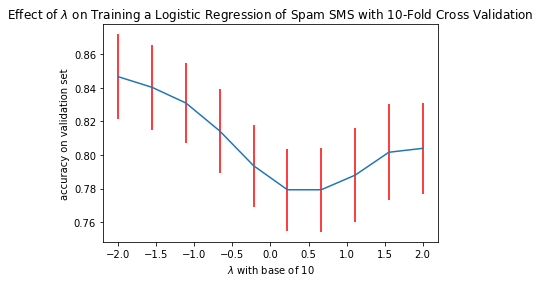

In [247]:
plt.errorbar(np.log10(lambda_list),np.average(accuracy_array,axis=1),yerr=np.std(accuracy_array,axis=1),ecolor='r')
# plt.plot(lambda_list, accuracy_list)
plt.xlabel('$\lambda$ with base of 10')
plt.ylabel('accuracy on validation set')
plt.title('Effect of $\lambda$ on Training a Logistic Regression of Spam SMS with 10-Fold Cross Validation')

From the above plot we can see $\lambda=0.01$ is the best 


| $\lambda $| `0.01` | 0.0215443469003  |0.0464158883361|0.1|0.215443469003|0.464158883361|1.0|2.15443469003| 4.64158883361| 10.0|
|:------:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|
| validation set    | **0.846667**|0.840333| 0.831| 0.814333| 0.793667| 0.779333| 0.779333|0.788| 0.801667|0.804|


Use the $\lambda$ with highest accuracy to train on the whole training data and test the accuracy on test data

In [264]:
lambda_ = 0.01

w = np.zeros((X_train_tfidf_rd.shape[1], 1))
w = gradient_decent(X_train_tfidf_rd, y_train, w, lambda_)
print 'Accuracy on whole training data: {}%'.format(cal_accuracy(X_train_tfidf_rd, w, y_train)[0]*100)
print 'Accuracy on test data: {}%'.format(cal_accuracy(X_test_tfidf_rd, w, y_test)[0]*100)

0.01 6274 [[ 300.49854499]]
Accuracy on whole training data: 99.9333333333%
Accuracy on test data: 95.4121306376%


Logistic Regression takes about 6274 iterations and about 14.3 seconds to achieve 95.42% accuracy on the test data.

## Extra Credit 1

### Add bias term

Add a column of 1 to the data and add one more $\omega$ to train. We do not add the bias term when regularizing the gradient

In [21]:
bias_tmp = np.ones((X_train_tfidf_rd.shape[0], 1))
X_train_tfidf_bias = np.column_stack((bias_tmp, X_train_tfidf_rd))

bias_tmp = np.ones((X_test_tfidf_rd.shape[0], 1))
X_test_tfidf_bias = np.column_stack((bias_tmp, X_test_tfidf_rd))

In [305]:
def gradient_decent_bias(X, y, w, lambda_):
    iternum = 0
    alpha = 0.9
    max_iter = 10000
    ita = 2
    eps = 10**(-3)

    y_predict = sigmoid(np.dot(X, w))
    error = -sum(y * np.log(y_predict) +
                 (1 - y) * np.log(1-y_predict)) + lambda_ / 2.0 * np.dot(
                     w[1:, 0].transpose(), w[1:, 0])

    while iternum < max_iter:
        iternum = iternum + 1

        delta_w = np.dot(X.transpose(), (y_predict - y))
        delta_w[1:, 0] = +w[1:, 0] * lambda_
        w = w - (ita * iternum**(-alpha) * delta_w)
        y_predict = sigmoid(np.dot(X, w))
        y_predict[y_predict<10**(-5)] = 10**(-5)
        n_y_predict = 1 - y_predict
        n_y_predict[n_y_predict < 10**(-5)] = 10**(-5)
        new_error = -sum(y * np.log(y_predict) + (
            1 - y) * np.log(n_y_predict)) + lambda_ / 2.0 * np.dot(
                w[1:, 0].transpose(), w[1:, 0])

        if abs(error - new_error) < eps:
            break
        error = new_error


#         if iternum%100==0:
#             print lambda_,error
#     print lambda_,iternum,error,w
    return w

In [306]:
num_lambda = 10

split_indexes = gen_10_fold(X_train_tfidf_bias)
accuracy_array_bias = np.zeros((num_lambda, 10))

lambda_list = np.logspace(-2, 1, num=num_lambda)

for index, lambda_ in enumerate(lambda_list):
    for i in range(10):
        train_index = split_indexes[i][0]
        test_index = split_indexes[i][1]
        w = np.random.rand(X_train_tfidf_bias.shape[1], 1)
        X_train = X_train_tfidf_bias[train_index, :]
        t_train = y_train[train_index, :]

        X_test = X_train_tfidf_bias[test_index, :]
        t_test = y_train[test_index, :]

        w = gradient_decent_bias(X_train, t_train, w, lambda_)
        accuracy_array_bias[index][i] = cal_accuracy(X_test, w, t_test)
    print lambda_, sum(accuracy_array_bias[index, :]) / 10

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.01 0.861
0.0215443469003 0.861
0.0464158883361 0.861
0.1 0.861
0.215443469003 0.861
0.464158883361 0.861
1.0 0.861
2.15443469003 0.861
4.64158883361 0.861
10.0 0.861


Text(0.5,1,u'Effect of $\\lambda$ on Training a Logistic Regression of Spam SMS with bias term')

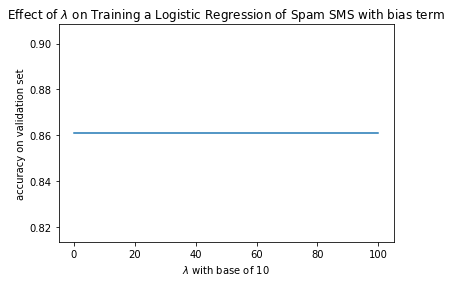

In [333]:
# plt.errorbar(np.log10(lambda_list),np.average(accuracy_array_bias,axis=1),yerr=np.std(accuracy_array_bias,axis=1),ecolor='r')
plt.plot(lambda_list, np.average(accuracy_array_bias,axis=1))
plt.xlabel('$\lambda$ with base of 10')
plt.ylabel('accuracy on validation set')
plt.title('Effect of $\lambda$ on Training a Logistic Regression of Spam SMS with bias term')

From the above plot we can see all $\lambda$ have the same result 

Use the $\lambda$ with highest accuracy to train on the whole training data and test the accuracy on test data

In [341]:
lambda_ = 0.01

w = np.random.rand(X_train_tfidf_bias.shape[1], 1)
w = gradient_decent_bias(X_train_tfidf_bias, y_train, w, lambda_)
print 'Accuracy on whole training data: {}%'.format(cal_accuracy(X_train_tfidf_bias, w, y_train)[0]*100)
print 'Accuracy on test data: {}%'.format(cal_accuracy(X_test_tfidf_bias, w, y_test)[0]*100)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


Accuracy on whole training data: 85.7666666667%
Accuracy on test data: 86.8973561431%


In [331]:
print w

[[-17.01531678]
 [  0.63737074]
 [  0.254575  ]
 ..., 
 [  0.02611199]
 [  0.19443915]
 [  0.68790573]]


In [340]:
lambda_ = 10

w = np.random.rand(X_train_tfidf_bias.shape[1], 1)
w = gradient_decent_bias(X_train_tfidf_bias, y_train, w, lambda_)
print 'Accuracy on whole training data: {}%'.format(cal_accuracy(X_train_tfidf_bias, w, y_train)[0]*100)
print 'Accuracy on test data: {}%'.format(cal_accuracy(X_test_tfidf_bias, w, y_test)[0]*100)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


Accuracy on whole training data: 86.1%
Accuracy on test data: 87.1695178849%


In [337]:
print w

[[ -5.68935470e+03]
 [ -5.60170546e-07]
 [ -8.78650205e-07]
 ..., 
 [ -3.76902160e-07]
 [ -3.11439612e-07]
 [ -1.63683667e-07]]


You can see the $\omega$ for the bias term is very big. In this case the regularization term is not as important as it is. Also it largely depends on the initialization. Therefore causing the performance to be similar on all $\lambda$ choice.

## Extra Credit 2

### Use Different Regularizer

Regularizer used is $\lambda ||\omega||_1$

In [35]:
def gradient_decent_2(X, y, w, lambda_):
    iternum = 0
    alpha = 0.9
    max_iter = 10000
    ita = 2
    eps = 10**(-3)

    y_predict = sigmoid(np.dot(X, w))
    error = -sum(y * np.log(y_predict) +
                 (1 - y) * np.log(1 - y_predict)) + lambda_ * sum(
                     np.absolute(w))

    while iternum < max_iter:
        iternum = iternum + 1

        delta_w = np.dot(X.transpose(), (y_predict - y)) + lambda_
        w = w - (ita * iternum**(-alpha) * delta_w)
        y_predict = sigmoid(np.dot(X, w))
        n_y_predict = 1 - y_predict
        n_y_predict[n_y_predict < 10**(-5)] = 10**(-5)
        new_error = -sum(y * np.log(y_predict) +
                         (1 - y) * np.log(n_y_predict)) + lambda_ * sum(
                             np.absolute(w))

        if abs(error - new_error) < eps:
            break
        error = new_error


#         if iternum%100==0:
#             print lambda_,error
#     print lambda_,iternum,error
    return w

In [36]:
num_lambda = 10

split_indexes = gen_10_fold(X_train_tfidf_rd)
accuracy_array_2 = np.zeros((num_lambda, 10))

lambda_list = np.logspace(-2, 1, num=num_lambda)

for index, lambda_ in enumerate(lambda_list):
    for i in range(10):
        train_index = split_indexes[i][0]
        test_index = split_indexes[i][1]
        w = np.zeros((X_train_tfidf_rd.shape[1], 1))
        X_train = X_train_tfidf_rd[train_index, :]
        t_train = y_train[train_index, :]

        X_test = X_train_tfidf_rd[test_index, :]
        t_test = y_train[test_index, :]

        w = gradient_decent_2(X_train, t_train, w, lambda_)
        accuracy_array_2[index][i] = cal_accuracy(X_test, w, t_test)
    print lambda_, sum(accuracy_array_2[index, :]) / 10

0.01 0.847333333333
0.0215443469003 0.844666666667
0.0464158883361 0.836333333333
0.1 0.775666666667
0.215443469003 0.715666666667
0.464158883361 0.670333333333
1.0 0.635333333333
2.15443469003 0.604
4.64158883361 0.584


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in multiply


10.0 0.556333333333


Text(0.5,1,u'Effect of $\\lambda$ on Training a Logistic Regression of Spam SMS with Different Regularizer')

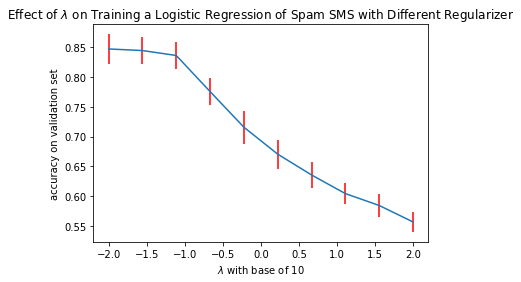

In [252]:
plt.errorbar(np.log10(lambda_list),np.average(accuracy_array_2,axis=1),yerr=np.std(accuracy_array_2,axis=1),ecolor='r')
# plt.plot(lambda_list, accuracy_list)
plt.xlabel('$\lambda$ with base of 10')
plt.ylabel('accuracy on validation set')
plt.title('Effect of $\lambda$ on Training a Logistic Regression of Spam SMS with Different Regularizer')

From the above plot we can see $\lambda=0.01$ is the best 

| $\lambda $| `0.01` | 0.0215443469003  |0.0464158883361|0.1|0.215443469003|0.464158883361|1.0|2.15443469003| 4.64158883361| 10.0|
|:------:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|
| validation set    | **0.847333**|0.844667|0.836333| 0.775667| 0.715667| 0.670333| 0.635333|0.604|  0.584|0.556333|


Use the $\lambda$ with highest accuracy to train on the whole training data and test the accuracy on test data

In [262]:
lambda_ = 0.01

w = np.zeros((X_train_tfidf_rd.shape[1], 1))
w = gradient_decent_2(X_train_tfidf_rd, y_train, w, lambda_)
print 'Accuracy on whole training data: {}%'.format(cal_accuracy(X_train_tfidf_rd, w, y_train)[0]*100)
print 'Accuracy on test data: {}%'.format(cal_accuracy(X_test_tfidf_rd, w, y_test)[0]*100)

Accuracy on whole training data: 99.9666666667%
Accuracy on test data: 95.3732503888%


## Extra Credit 3

### EG $\pm$

Use Exponentiated Gradient Decent for training and use two vector of $\omega$, one for the positive parameter and one for the negative parameter.

We use $w^+-w^-$ to replace $w$ in the loss function. Therefore we can use $\frac{\partial E(w^+-w^-)}{\partial w}\frac{\partial w}{\partial w^{\pm}}$ when calculating the deravative.

In [216]:
def exponentiated_gradient_decent(X, y, w_pos, w_neg, lambda_):
    iternum = 0
    alpha = 0.9
    max_iter = 10000
    ita = 0.1
    eps = 10**(-3)

    y_predict = sigmoid(np.dot(X, (w_pos - w_neg)))
    error = -sum(y * np.log(y_predict) +
                 (1 - y) * np.log(1 - y_predict)) + lambda_ / 2.0 * (
                     np.dot(w_pos.transpose(), w_pos) +
                     np.dot(w_neg.transpose(), w_neg))

    while iternum < max_iter:
        iternum = iternum + 1

        delta_w_pos = np.dot(X.transpose(), (y_predict - y)) + w_pos * lambda_
        w_pos = w_pos * np.exp(-ita * iternum**(-alpha) * delta_w_pos)

        y_predict = sigmoid(np.dot(X, (w_pos - w_neg)))
        delta_w_neg = -np.dot(X.transpose(), (y_predict - y)) - w_neg * lambda_
        w_neg = w_neg * np.exp(ita * iternum**(-alpha) * delta_w_neg)

        y_predict = sigmoid(np.dot(X, (w_pos - w_neg)))
        n_y_predict = 1 - y_predict
        n_y_predict[n_y_predict < 10**(-5)] = 10**(-5)
        new_error = -sum(y * np.log(y_predict) + (
            1 - y) * np.log(n_y_predict)) + lambda_ / 2.0 * np.dot(
                (w_pos - w_neg).transpose(), (w_pos - w_neg))

        if abs(error - new_error) < eps:
            break
        error = new_error

#         if iternum % 1000 == 0:
#             print lambda_, error


#     print lambda_,iternum,error
    return w_pos,w_neg

In [225]:
num_lambda = 10

split_indexes = gen_10_fold(X_train_tfidf_rd)
accuracy_array_eg = np.zeros((num_lambda, 10))

lambda_list = np.logspace(-2, 1, num=num_lambda)

for index, lambda_ in enumerate(lambda_list):
    for i in range(10):
        train_index = split_indexes[i][0]
        test_index = split_indexes[i][1]

        w_pos = np.ones((X_train_tfidf_rd.shape[1], 1))
        w_neg = np.ones((X_train_tfidf_rd.shape[1], 1))
        X_train = X_train_tfidf_rd[train_index, :]
        t_train = y_train[train_index, :]

        X_test = X_train_tfidf_rd[test_index, :]
        t_test = y_train[test_index, :]

        w_pos,w_neg = exponentiated_gradient_decent(X_train, t_train, w_pos, w_neg,
                                          lambda_)
        accuracy_array_eg[index][i] = cal_accuracy(X_test, w_pos - w_neg, t_test)
    print lambda_, sum(accuracy_array_eg[index, :]) / 10

0.01 0.831333333333
0.0215443469003 0.832333333333
0.0464158883361 0.826666666667
0.1 0.824333333333
0.215443469003 0.816666666667
0.464158883361 0.536
1.0 0.439
2.15443469003 0.431
4.64158883361 0.459666666667
10.0 0.437333333333


Text(0.5,1,u'Effect of $\\lambda$ on Training a Logistic Regression of Spam SMS with EG $\\pm$')

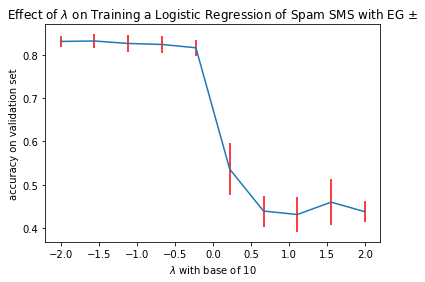

In [254]:
plt.errorbar(np.log10(lambda_list),np.average(accuracy_array_eg,axis=1),yerr=np.std(accuracy_array_eg,axis=1),ecolor='r')
# plt.plot(lambda_list, accuracy_list)
plt.xlabel('$\lambda$ with base of 10')
plt.ylabel('accuracy on validation set')
plt.title('Effect of $\lambda$ on Training a Logistic Regression of Spam SMS with EG $\pm$')

From the above plot we can see $\lambda=0.0464158883361$ is the best 

| $\lambda $| 0.01 | 0.0215443469003  |`0.0464158883361`|0.1|0.215443469003|0.464158883361|1.0|2.15443469003| 4.64158883361| 10.0|
|:------:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|
| validation set    | 0.831333|0.832333|**0.826667**| 0.824333|0.816667|0.536| 0.439|0.431| 0.459667|0.437333|


Use the $\lambda$ with highest accuracy to train on the whole training data and test the accuracy on test data

In [261]:
lambda_ = 0.0464158883361

w_pos = np.ones((X_train_tfidf_rd.shape[1], 1))
w_neg = np.ones((X_train_tfidf_rd.shape[1], 1))
w_pos,w_neg = exponentiated_gradient_decent(X_train_tfidf_rd, y_train, w_pos,w_neg, lambda_)
print 'Accuracy on whole training data: {}%'.format(cal_accuracy(X_train_tfidf_rd, (w_pos-w_neg), y_train)[0]*100)
print 'Accuracy on test data: {}%'.format(cal_accuracy(X_test_tfidf_rd, (w_pos-w_neg), y_test)[0]*100)

Accuracy on whole training data: 83.7333333333%
Accuracy on test data: 81.8040435459%


## Extra Credit 4

### Weighted Linear Least Squares

The main idea is the same. We use 

$$w=w-H^{-1}\nabla E(w)$$

to change $w$.

And $H=\nabla\nabla E(w)=\Phi^TR\Phi$.

When add regularization term, we will introduce a diagnol matrix $\lambda I$, where $I$ is a identity matrix.

$$H=\Phi^T R\Phi+\lambda I$$

In [327]:
def gradient_decent_lls(X, y, w, lambda_):
    iternum = 0
    alpha = 0.9
    max_iter = 10000
    ita = 1
    eps = 10**(-3)

    y_predict = sigmoid(np.dot(X, w))
    n_y_predict = 1 - y_predict
    n_y_predict[n_y_predict < 10**(-5)] = 10**(-5)
    error = -sum(y * np.log(y_predict) +
                 (1 - y) * np.log(n_y_predict)) + lambda_ / 2.0 * np.dot(
                     w.transpose(), w)

    while iternum < max_iter:
        iternum = iternum + 1

        R = np.diag((y_predict * n_y_predict).flatten())
        diag_lambda = np.zeros((w.shape[0],w.shape[0]))
        np.fill_diagonal(diag_lambda,lambda_)
        H = np.dot(np.dot(X.transpose(), R), X)+diag_lambda
        delta_w = np.dot(X.transpose(), (y_predict - y)) + w * lambda_
        w = w - ita*iternum**(-alpha)*np.dot(np.linalg.inv(H), delta_w)
        y_predict = sigmoid(np.dot(X, w))
        n_y_predict = 1 - y_predict
        n_y_predict[n_y_predict < 10**(-5)] = 10**(-5)
        new_error = -sum(y * np.log(y_predict) + (1 - y) * np.log(n_y_predict)
                         ) + lambda_ / 2.0 * np.dot(w.transpose(), w)

        if abs(error - new_error) < eps:
            break
        error = new_error

#         if iternum % 100 == 0:
#             print lambda_, error


    print "Iteration number: {}, stop error: {}".format(iternum,error)
    return w

In [307]:
num_lambda = 10

split_indexes = gen_10_fold(X_train_tfidf_rd)
accuracy_array_lls = np.zeros((num_lambda, 10))

lambda_list = np.logspace(-2, 2, num=num_lambda)

for index, lambda_ in enumerate(lambda_list):
    for i in range(10):
        train_index = split_indexes[i][0]
        test_index = split_indexes[i][1]
        w = np.zeros((X_train_tfidf_rd.shape[1], 1))
        X_train = X_train_tfidf_rd[train_index, :]
        t_train = y_train[train_index, :]

        X_test = X_train_tfidf_rd[test_index, :]
        t_test = y_train[test_index, :]

        w = gradient_decent_lls(X_train, t_train, w, lambda_)
        accuracy_array_lls[index][i] = cal_accuracy(X_test, w, t_test)
    print lambda_, sum(accuracy_array_lls[index, :]) / 10

0.01 0.783
0.0278255940221 0.778
0.0774263682681 0.775333333333
0.215443469003 0.775
0.599484250319 0.768
1.6681005372 0.780333333333
4.64158883361 0.791666666667
12.9154966501 0.799333333333
35.938136638 0.801666666667
100.0 0.801666666667


Text(0.5,1,u'Effect of $\\lambda$ on Training a Logistic Regression of Spam SMS with 10-Fold Cross Validation')

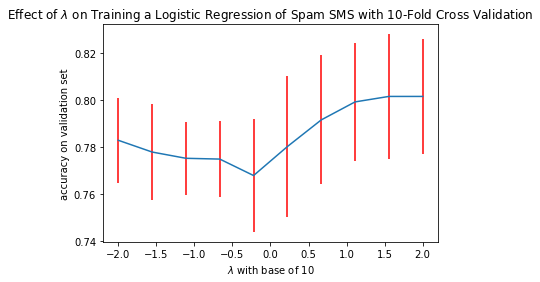

In [309]:
plt.errorbar(np.log10(lambda_list),np.average(accuracy_array_lls,axis=1),yerr=np.std(accuracy_array_lls,axis=1),ecolor='r')
# plt.plot(lambda_list, accuracy_list)
plt.xlabel('$\lambda$ with base of 10')
plt.ylabel('accuracy on validation set')
plt.title('Effect of $\lambda$ on Training a Logistic Regression of Spam SMS with 10-Fold Cross Validation')

From the above plot we can see $\lambda=100$ and $\lambda=35.938136638$ is the best, but after future analysis, this is not true.

| $\lambda $| 0.01 |0.0278255940221|0.0774263682681|0.215443469003|0.599484250319|1.6681005372|4.64158883361|12.9154966501| `35.938136638`| `100.0`|
|:------:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|
| validation set    | 0.783| 0.778|0.775333| 0.775| 0.768|  0.780333| 0.779333|0.799333|**0.801667**|**0.801667**|


Use the $\lambda$ with highest accuracy to train on the whole training data and test the accuracy on test data

In [328]:
lambda_ = 0.01

w = np.zeros((X_train_tfidf_rd.shape[1], 1))
w = gradient_decent_lls(X_train_tfidf_rd, y_train, w, lambda_)
print 'Accuracy on whole training data: {}%'.format(cal_accuracy(X_train_tfidf_rd, w, y_train)[0]*100)
print 'Accuracy on test data: {}%'.format(cal_accuracy(X_test_tfidf_rd, w, y_test)[0]*100)

Iteration number: 127, stop error: [[ 284.97496985]]
Accuracy on whole training data: 100.0%
Accuracy on test data: 95.7231726283%


In [329]:
lambda_ = 35.938136638

w = np.zeros((X_train_tfidf_rd.shape[1], 1))
w = gradient_decent_lls(X_train_tfidf_rd, y_train, w, lambda_)
print 'Accuracy on whole training data: {}%'.format(cal_accuracy(X_train_tfidf_rd, w, y_train)[0]*100)
print 'Accuracy on test data: {}%'.format(cal_accuracy(X_test_tfidf_rd, w, y_test)[0]*100)

Iteration number: 2, stop error: [[ 2033.24406182]]
Accuracy on whole training data: 89.0%
Accuracy on test data: 87.2083981337%


From the above test we can see, LLS does use less iterations, about 127 to reach converge.

From the above we can see, when we use larger $\lambda$, it increase the validation accuracy, but the error is large because larger lambda means larger amount of weight $\omega$ plays in the loss. We can see it use only 2 iterations as the most of the loss is introduced by $\omega$.

When using smaller $\lambda$, we reduce the error to fit on the data. In this way, we have lower validation accuracy compared with too large $\lambda$.

Therefore, we should use $\lambda$ smaller than 4.64158883361, as the accuracy increase because of larger $\lambda$. From the plot we draw, we can see the best $\lambda$ is 0.01 and is consistent with the previous result. 

## Extra Credit 5

### Stochastic Gradient Descent

Use Stochastic Gradient Descent to train the data and see the converge speed.

In [228]:
def stochastic_gradient_decent(X, y, w, lambda_):
    #     iternum = 0
    alpha = 0.9
    #     max_iter = 10000
    ita = 2

    for i in range(X.shape[0]):
        y_predict = sigmoid(np.dot(X[i, :], w))
        delta_w = X[i, :] * (y_predict - y[i]) + lambda_ * w
        w = w - (ita * (i + 1)**(1 - alpha) * delta_w)

        test_w = w.reshape(X.shape[1], 1)
        y_predict = sigmoid(np.dot(X, test_w))
        n_y_predict = 1 - y_predict
        n_y_predict[n_y_predict < 10**(-5)] = 10**(-5)
        error = -sum(y * np.log(y_predict) +
                     (1 - y) * np.log(n_y_predict)) + lambda_ / 2.0 * np.dot(
                         test_w.transpose(), test_w)


#         if i % 1000 == 0:
#             print lambda_, error
#     print lambda_, error
    return w

In [233]:
num_lambda = 10

split_indexes = gen_10_fold(X_train_tfidf_rd)
accuracy_array_sgd = np.zeros((num_lambda, 10))

lambda_list = np.logspace(-5, -1, num=num_lambda)

for index, lambda_ in enumerate(lambda_list):
    for i in range(10):
        train_index = split_indexes[i][0]
        test_index = split_indexes[i][1]
        w = np.zeros((X_train_tfidf_rd.shape[1]))
        X_train = X_train_tfidf_rd[train_index, :]
        t_train = y_train[train_index, :]

        X_test = X_train_tfidf_rd[test_index, :]
        t_test = y_train[test_index, :]

        w = stochastic_gradient_decent(X_train, t_train, w, lambda_)
        w = w.reshape(X_train_tfidf_rd.shape[1], 1)
        accuracy_array_sgd[index][i] = cal_accuracy(X_test, w, t_test)
    print lambda_, sum(accuracy_array_sgd[index, :]) / 10

1e-05 0.798666666667
2.78255940221e-05 0.793
7.74263682681e-05 0.779666666667
0.000215443469003 0.751
0.000599484250319 0.693666666667
0.0016681005372 0.654
0.00464158883361 0.605666666667
0.0129154966501 0.535
0.035938136638 0.443666666667
0.1 0.348666666667


Text(0.5,1,u'Effect of $\\lambda$ on Training a Logistic Regression of Spam SMS with Stochastic Gradient Descent')

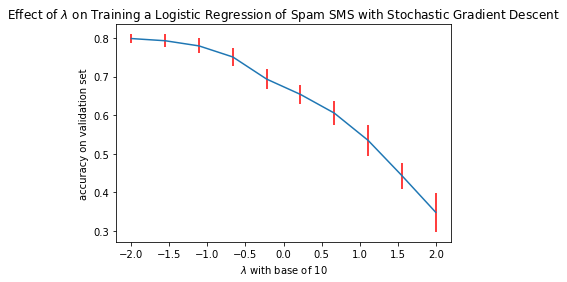

In [258]:
plt.errorbar(np.log10(lambda_list),np.average(accuracy_array_sgd,axis=1),yerr=np.std(accuracy_array_sgd,axis=1),ecolor='r')
# plt.plot(lambda_list, accuracy_list)
plt.xlabel('$\lambda$ with base of 10')
plt.ylabel('accuracy on validation set')
plt.title('Effect of $\lambda$ on Training a Logistic Regression of Spam SMS with Stochastic Gradient Descent')

From the above plot we can see $\lambda=10^{-5}$ is the best 

| $\lambda $| `1e-05` | 2.78255940221e-05  |7.74263682681e-05|0.000215443469003|0.000599484250319|0.0016681005372|0.00464158883361|0.0129154966501| 0.035938136638| 0.1|
|:------:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|
| validation set    | **0.798667**| 0.793|0.779667| 0.751|  0.693667| 0.654| 0.605667| 0.535| 0.443667| 0.348667|


Use the $\lambda$ with highest accuracy to train on the whole training data and test the accuracy on test data

In [260]:
lambda_ = 10**(-5)

w = np.zeros((X_train_tfidf_rd.shape[1]))
w = stochastic_gradient_decent(X_train_tfidf_rd, y_train, w, lambda_)
w = w.reshape(X_train_tfidf_rd.shape[1], 1)
print 'Accuracy on whole training data: {}%'.format(cal_accuracy(X_train_tfidf_rd, w, y_train)[0]*100)
print 'Accuracy on test data: {}%'.format(cal_accuracy(X_test_tfidf_rd, w, y_test)[0]*100)

Accuracy on whole training data: 94.6333333333%
Accuracy on test data: 91.7962674961%


The time used for SGD is 23 secons and iteration number is 3000 (the number of samples).

You can see SGD can achieve similar performance with much fewer iterations.

The time used for SGD is longer because it's using for loop instead of matrix operation which is highly optimized in numpy. For larger number of data, we think SGD will save a lot of time.